<a href="https://colab.research.google.com/github/FGalvao77/Uma-introducao-pratica-aos-retornos-de-chamada-do-Keras/blob/main/Uma_introdu%C3%A7%C3%A3o_pr%C3%A1tica_aos_retornos_de_chamada_do_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Uma introdução prática aos retornos de chamada do `Keras`**

---



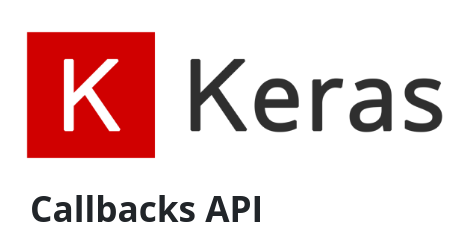

- https://keras.io/api/callbacks/

### **1. Introdução**

Iremos aprender com esse tutorial aplicação das **APIs de retorno de chamada** do `Keras` mais comumente usadas.

Ao treinar um modelo de aprendizado de máquina, gostaríamos de ter a capacidade de monitorar o desempenho do modelo e executar certas ações dependendo dessas medidas de desempenho. É aí que entram os _retornos de chamada_ do Keras.

_`Callbacks` são um tipo importante de objeto TensorFlow e Keras que são projetados para monitorar o desempenho das métricas em certos pontos da execução do treinamento e realizar alguma ação que pode depender desse desempenho nos valores das métricas._

Exploraremos as seguintes APIs mais populares de retorno de chamada, são elas:

1. `EarlyStopping`: um retorno de chamada projetado para parada precoce;
2. `CSVLogger`: um retorno de chamada transmite resultados de época para um arquivo CSV;
3. `ModelCheckpoint`: um retorno de chamada para salvar o modelo Keras ou o peso do modelo durante o treinamento;
4. `ReduceLROnPlateau`: um retorno de chamada para reduzir a taxa de aprendizagem quando uma métrica para de melhorar;
5. `LearningRateScheduler`: um retorno de chamada para programações de taxas de aprendizagem e,
6. `LambdaCallback`: um retorno de chamada para criar retornos de chamada personalizados dinamicamente.

Depois dessa breve introdução, vamos entender melhor com exemplos práticos!

_Let's go baby!!!_

### **2. Preparando o ambiente**

In [ ]:
# importando as bibliotecas e as funções
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

**Função auxiliar para as métricas**

In [ ]:
# função para as métricas
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_' + metric]
    epochs = range(1, len(train_metrics) + 1)

    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training & Validation - ' + metric)

    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend(['train_' + metric, 
                'val_' + metric])
    
    plt.show();

In [ ]:
# função para taxa de aprendizagem
def plot_learning_rate(history):
    learning_rate = history.history['lr']
    epochs = range(1, len(learning_rate) + 1)

    plt.plot(epochs, learning_rate)
    plt.title('Learning rate')
    plt.xlabel('Epochs')
    plt.ylabel('Learning rate')

    plt.show();

In [ ]:
# função para avaliação da acurácia e perda do teste
def get_test_accuracy(model, x_test, y_test):
    test_loss, test_acc = model.evaluate(x = x_test,
                                         y = y_test, 
                                         verbose=0)
    
    print('accuracy: {acc:0.3f}'.format(acc = test_acc))
    print('loss: {acc:0.3f}'.format(acc = test_loss))

### **3. Importando o conjunto de dados**

Para atividade prática, utilizaremos o famoso **dataset** `Fashion MNIST` que, por sinal já vem embutido dentro do _Keras_.

Podemos importá-lo utilizando o seguinte comando.

```python
keras.datasets.fashion_mnist
```

In [ ]:
# importando o conjunto de dados e instanciando na variável "fashion_mnist"
fashion_mnist = keras.datasets.fashion_mnist

In [ ]:
# realizando a separação entre dados de treino e teste
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [ ]:
# visualizando a dimensão dos dados particionados
X_train_full.shape, y_train_full.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [ ]:
# visualizando o tipo do objeto
X_train_full.dtype

dtype('uint8')

In [ ]:
# para um treinamento mais rápido, vamos usar um subconjunto de 10.000 imagens
X_train, y_train = X_train_full[:10_000] / 255.0, y_train_full[:10_000]

In [ ]:
# visualizando a dimensão dos dados de treino
X_train.shape, y_train.shape

((10000, 28, 28), (10000,))

### **4. Construindo o modelo**

In [ ]:
# importando as funções necessaŕias para construção do modelo e suas camadas
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

In [ ]:
# criando uma função para aplicação do modelo 
def create_model():  
    model = Sequential([
        Flatten(input_shape=(28, 28)),
        Dense(300, activation='relu'),
        Dense(100, activation='relu'),
        Dense(10, activation='softmax'),
    ])

    model.compile(
        optimizer='sgd', 
        loss='sparse_categorical_crossentropy', 
        metrics=['accuracy']
    )

    return model

In [ ]:
# instanciando a função do modelo criado
model = create_model()

# visualizando o sumaŕio do modelo
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


### **5. Aplicando o retorno de chamada - `Callbacks API`**

#### **5.1. EarlyStopping**

`EarlyStopping` é um retorno de chamada integrado projetado para parada antecipada . 

Primeiro, vamos importá-lo e criar um objeto de parada antecipada.

In [ ]:
# importando a função
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# instanciando a função
early_stopping = EarlyStopping()

In [ ]:
# realizando o treinamento do modelo e instanciando o objeto para guardar o histórico do treino
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    validation_split=0.20,
    batch_size=64,
    verbose=2,
    callbacks=[early_stopping]
)

Epoch 1/50
125/125 - 1s - loss: 1.5205 - accuracy: 0.5665 - val_loss: 1.1013 - val_accuracy: 0.6590


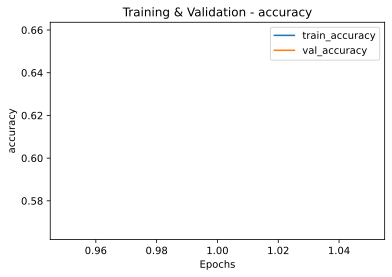

In [ ]:
# plotando o gráfico da acurácia
plot_metric(history, 'accuracy')

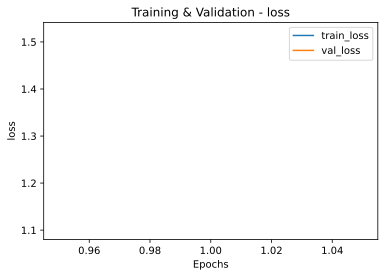

In [ ]:
# plotando o gráfico da perda
plot_metric(history, 'loss')

##### **5.1.1. Personalizando a parada antecipada**

In [ ]:
# criando um novo modelo
model = create_model()

In [ ]:
# definindo os parâmetros para a parada antecipada
custom_early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    min_delta=0.001,
    mode='max'
)

> - `monitor = val_accuracy`, para usar a acurácia de validação como medida de desempenho para encerrar o treinamento.
- `monitor = 'val_loss'`: para usar a perda de validação como medida de desempenho para encerrar o treinamento.<br><br>
- `patience = 3`: é o número de épocas sem melhora. O valor **3** significa que o treinamento é encerrado assim que a medida de desempenho piorar em três épocas.

> **Argumentos:**

- **`monitor`**: Quantidade a ser monitorada.
- **`min_delta`**: A mudança mínima na quantidade monitorada para se qualificar como uma melhoria, ou seja, uma mudança absoluta inferior a **_min_delta_**, contará como nenhuma melhoria.
- **`patience`**: Número de épocas sem melhora, após as quais o treinamento será interrompido.
- **`verbose`**: Modo de verbosidade..
- **`mode`**: Um de `{"auto", "min", "max"}`. No modo `"min"`, o treinamento irá parar quando a quantidade monitorada parar de diminuir; no modo `"max"` irá parar quando a quantidade monitorada parar de aumentar; no modo `"auto"`, a direção é inferida automaticamente a partir do nome da quantidade monitorada.
- **`baseline`**: Valor da linha de base para a quantidade monitorada. O treinamento será interrompido se o modelo não mostrar melhorias em relação à linha de base.
- **`restore_best_weights`**: Se deve restaurar os pesos do modelo da época com o melhor valor da quantidade monitorada. Se for False, os pesos do modelo obtidos na última etapa do treinamento serão usados. Uma época será restaurada independentemente do desempenho em relação à `linha de base` (**baseline**). Se nenhuma época melhorar na linha de base, o treinamento será executado em épocas de `patience` e restaurará os pesos da melhor época naquele conjunto.



In [ ]:
# treinando o modelo com a parada antecipada personalizada
history_custom = model.fit(
    X_train,
    y_train, 
    epochs=50,
    validation_split=0.20,
    batch_size=64, 
    verbose=2,
    callbacks=[custom_early_stopping]
)

Epoch 1/50
125/125 - 1s - loss: 1.5710 - accuracy: 0.5309 - val_loss: 1.1390 - val_accuracy: 0.6420
Epoch 2/50
125/125 - 1s - loss: 0.9682 - accuracy: 0.6864 - val_loss: 0.8785 - val_accuracy: 0.6935
Epoch 3/50
125/125 - 1s - loss: 0.8021 - accuracy: 0.7326 - val_loss: 0.7759 - val_accuracy: 0.7375
Epoch 4/50
125/125 - 1s - loss: 0.7198 - accuracy: 0.7595 - val_loss: 0.7116 - val_accuracy: 0.7650
Epoch 5/50
125/125 - 1s - loss: 0.6652 - accuracy: 0.7834 - val_loss: 0.6690 - val_accuracy: 0.7730
Epoch 6/50
125/125 - 1s - loss: 0.6256 - accuracy: 0.7935 - val_loss: 0.6356 - val_accuracy: 0.7785
Epoch 7/50
125/125 - 1s - loss: 0.5945 - accuracy: 0.8034 - val_loss: 0.6121 - val_accuracy: 0.7855
Epoch 8/50
125/125 - 1s - loss: 0.5678 - accuracy: 0.8116 - val_loss: 0.5863 - val_accuracy: 0.8005
Epoch 9/50
125/125 - 1s - loss: 0.5491 - accuracy: 0.8149 - val_loss: 0.5912 - val_accuracy: 0.7920
Epoch 10/50
125/125 - 1s - loss: 0.5310 - accuracy: 0.8186 - val_loss: 0.5566 - val_accuracy: 0.8050

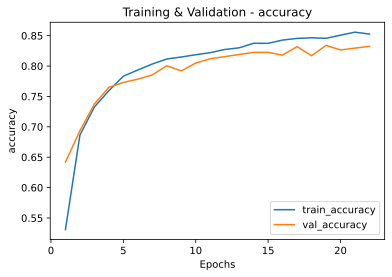

In [ ]:
# plotando o gráfico da acurácia
plot_metric(history_custom, 'accuracy')

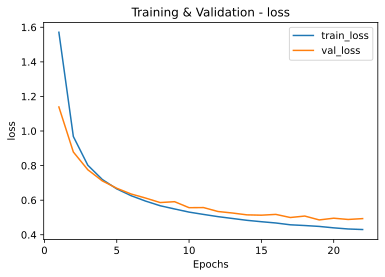

In [ ]:
# plotando o gráfico da perda
plot_metric(history_custom, 'loss')

#### **5.2. CSVLogger**

`CSVLogger` é um retorno de chamada que transmite os resultados da época para um arquivo CSV. 

Primeiro, vamos importá-lo e criar um objeto com o _CSVLogger_.

In [ ]:
# importando a função
from tensorflow.keras.callbacks import CSVLogger

In [ ]:
# criando um objeto com a função importada e como argumento instanciando um arquivo ".csv"
csv_log = CSVLogger('results.csv')

In [ ]:
# criando o modelo
modelo = create_model()

In [ ]:
# treinando o modelo
history_csv_logger = model.fit(
    X_train,
    y_train,
    epochs=10,
    validation_split=0.20,
    batch_size=64,
    verbose=2,
    callbacks=[csv_log]
)

Epoch 1/10
125/125 - 1s - loss: 0.4226 - accuracy: 0.8559 - val_loss: 0.4799 - val_accuracy: 0.8315
Epoch 2/10
125/125 - 1s - loss: 0.4182 - accuracy: 0.8577 - val_loss: 0.4923 - val_accuracy: 0.8255
Epoch 3/10
125/125 - 1s - loss: 0.4132 - accuracy: 0.8627 - val_loss: 0.4767 - val_accuracy: 0.8375
Epoch 4/10
125/125 - 1s - loss: 0.4087 - accuracy: 0.8587 - val_loss: 0.4674 - val_accuracy: 0.8365
Epoch 5/10
125/125 - 1s - loss: 0.4035 - accuracy: 0.8629 - val_loss: 0.5027 - val_accuracy: 0.8130
Epoch 6/10
125/125 - 1s - loss: 0.3980 - accuracy: 0.8659 - val_loss: 0.4557 - val_accuracy: 0.8420
Epoch 7/10
125/125 - 1s - loss: 0.3968 - accuracy: 0.8681 - val_loss: 0.4565 - val_accuracy: 0.8405
Epoch 8/10
125/125 - 1s - loss: 0.3901 - accuracy: 0.8668 - val_loss: 0.4580 - val_accuracy: 0.8355
Epoch 9/10
125/125 - 1s - loss: 0.3886 - accuracy: 0.8677 - val_loss: 0.4676 - val_accuracy: 0.8340
Epoch 10/10
125/125 - 1s - loss: 0.3828 - accuracy: 0.8698 - val_loss: 0.4594 - val_accuracy: 0.8410

In [ ]:
# importando a biblioteca pandas
import pandas as pd

In [ ]:
# visualizando o arquivo "results.csv"
pd.read_csv('results.csv', index_col='epoch')

,accuracy,loss,val_accuracy,val_loss
epoch,,,,
0,0.855875,0.422626,0.8315,0.479880
1,0.857750,0.418176,0.8255,0.492291
2,0.862750,0.413203,0.8375,0.476654
3,0.858750,0.408651,0.8365,0.467431
4,0.862875,0.403476,0.8130,0.502654
5,0.865875,0.397972,0.8420,0.455667
6,0.868125,0.396842,0.8405,0.456503
7,0.866750,0.390097,0.8355,0.457951
8,0.867750,0.388576,0.8340,0.467577


Além do argumento obrigatório `filename`, as outras duas opções são:
- **`separator`**: string usada para separar elementos no arquivo CSV e, - **`append`**: é booleano e o padrão é `False`.
 - `True`: serve para anexar se o arquivo existir (útil para continuar o treinamento). 
  - `False`: substituir arquivo existente.

#### **5.3. ModelCheckpoint**

`ModelCheckpoint` é um retorno de chamada para salvar o modelo **Keras** ou o peso do modelo durante o treinamento, para que o modelo ou os pesos possam ser carregados posteriormente para continuar o treinamento a partir do estado salvo.

Primeiro, vamos importá-lo e criar um objeto com o _ModelCheckpoint_.

In [ ]:
# importando a função
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
# instanciando um "checkpoint"
checkpoint_path = 'model_checkpoints/'

In [ ]:
# criando um objeto com a função importada e definindo o ponto de checagem com o objeto "checkpoint_path"
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    save_freq='epoch',
    save_weights_only=True,
    verbose=1
)

In [ ]:
# criando o modelo para o treinamento
model = create_model()

In [ ]:
# treinando o modelo
history_checkpoint = model.fit(
    X_train,
    y_train,
    epochs=5,
    validation_split=0.20,
    batch_size=64,
    verbose=2,
    callbacks=[checkpoint]
)

Epoch 1/5
125/125 - 1s - loss: 0.5113 - accuracy: 0.8295 - val_loss: 0.5483 - val_accuracy: 0.8110

Epoch 00001: saving model to model_checkpoints/
Epoch 2/5
125/125 - 1s - loss: 0.4977 - accuracy: 0.8338 - val_loss: 0.5654 - val_accuracy: 0.7970

Epoch 00002: saving model to model_checkpoints/
Epoch 3/5
125/125 - 1s - loss: 0.4917 - accuracy: 0.8339 - val_loss: 0.5236 - val_accuracy: 0.8210

Epoch 00003: saving model to model_checkpoints/
Epoch 4/5
125/125 - 1s - loss: 0.4767 - accuracy: 0.8399 - val_loss: 0.5227 - val_accuracy: 0.8175

Epoch 00004: saving model to model_checkpoints/
Epoch 5/5
125/125 - 1s - loss: 0.4702 - accuracy: 0.8421 - val_loss: 0.5152 - val_accuracy: 0.8190

Epoch 00005: saving model to model_checkpoints/


In [ ]:
# visualizando as métricas - acurácia e perda
get_test_accuracy(model, X_test, y_test)

accuracy: 0.781
loss: 84.321


Vamos criar um novo modelo como `new_model` para demonstrar como funcionam os pesos de carregamento. E executando `get_test_accuracy(new_model, X_test, y_test)`, obtemos a precisão do teste de **0,086** para um modelo sem carregar nenhum peso treinado.

##### **5.3.1. Criando um novo modelo e carregando os pesos**

In [ ]:
# criando um novo modelo
new_model = create_model()

In [ ]:
# avaliando o modelo sem carregar os pesos
get_test_accuracy(new_model, X_test, y_test)

accuracy: 0.077
loss: 166.999


In [ ]:
# carregando os pesos
new_model.load_weights('model_checkpoints/')

In [ ]:
# agora teste-o e a precisão deve ser a mesma de antes
get_test_accuracy(new_model, X_test, y_test)

accuracy: 0.781
loss: 84.321


Os argumentos comumente usados ​​que você deve saber ao usar `ModelCheckpointcallback`, são eles:

- **`filepath´**: string ou `PathLike`, o caminho para salvar o arquivo de modelo. 
 - `filepathpode` conter opções de formatação nomeadas, por exemplo, se `filepath` for `weights.{epoch:02d}-{val_loss:.2f}`, os pontos de verificação do modelo serão salvos com o número da época e a perda de validação no nome do arquivo;
- **`save_freq`**: `'epoch'` ou inteiro. Ao usar `'epoch'`, o retorno de chamada salva o modelo após cada época. Ao usar o número inteiro, o retorno de chamada salva o modelo no final de muitos lotes e,
- **`save_weights_only`**: se `True`, então, apenas os pesos do modelo serão salvos (`model.save_weights(filepath)`), caso contrário, o modelo completo será salvo (`model.save(filepath)`).

#### **5.4. ReduceLROnPlateau**

`ReduceLROnPlateau` é um retorno de chamada para reduzir a taxa de aprendizado quando uma métrica para de melhorar. Esse retorno de chamada monitora uma quantidade e, se nenhuma melhoria for observada por patiencevárias épocas, a taxa de aprendizado será reduzida por um valor de `factor` (`new_lr = lr * factor`). Vamos ver como isso funciona com a ajuda de um exemplo.

Primeiro, vamos importá-lo e criar um objeto com o `ReduceLROnPlateau`.

In [ ]:
# importando a função
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [ ]:
# criando um objeto com a função e instanciando os parâmetros
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=0.001,
    verbose=2
)

In [ ]:
# criando um modelo
model = create_model()

In [ ]:
# treinando o modelo
history_reduce_lr = model.fit(
    X_train,
    y_train,
    epochs=50,
    validation_split=0.20,
    batch_size=64,
    verbose=2,
    callbacks=[reduce_lr]
)

Epoch 1/50
125/125 - 1s - loss: 1.6291 - accuracy: 0.5253 - val_loss: 1.1639 - val_accuracy: 0.6525
Epoch 2/50
125/125 - 1s - loss: 0.9673 - accuracy: 0.6976 - val_loss: 0.8821 - val_accuracy: 0.7260
Epoch 3/50
125/125 - 1s - loss: 0.7910 - accuracy: 0.7408 - val_loss: 0.7717 - val_accuracy: 0.7425
Epoch 4/50
125/125 - 1s - loss: 0.7116 - accuracy: 0.7654 - val_loss: 0.7067 - val_accuracy: 0.7665
Epoch 5/50
125/125 - 1s - loss: 0.6598 - accuracy: 0.7795 - val_loss: 0.6646 - val_accuracy: 0.7760
Epoch 6/50
125/125 - 1s - loss: 0.6243 - accuracy: 0.7937 - val_loss: 0.6377 - val_accuracy: 0.7760
Epoch 7/50
125/125 - 1s - loss: 0.5938 - accuracy: 0.8025 - val_loss: 0.6064 - val_accuracy: 0.7930
Epoch 8/50
125/125 - 1s - loss: 0.5700 - accuracy: 0.8101 - val_loss: 0.5943 - val_accuracy: 0.7920
Epoch 9/50
125/125 - 1s - loss: 0.5485 - accuracy: 0.8169 - val_loss: 0.5920 - val_accuracy: 0.7960
Epoch 10/50
125/125 - 1s - loss: 0.5326 - accuracy: 0.8223 - val_loss: 0.5693 - val_accuracy: 0.8020

Vamos representar graficamente a taxa de aprendizagem e a perda para obter uma imagem clara.

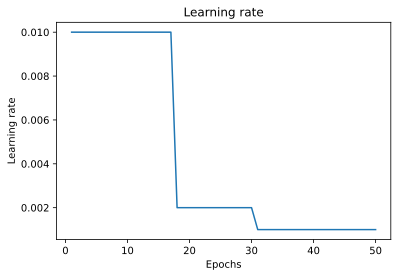

In [ ]:
# visualizando o histórico da taxa de aprendizagem
plot_learning_rate(history_reduce_lr)

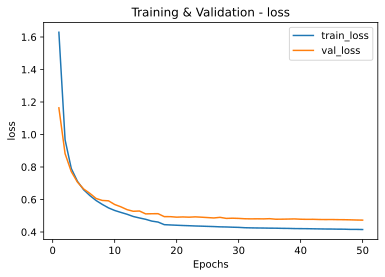

In [ ]:
# plotando o gráfico da perda - treinamento e validação
plot_metric(history_reduce_lr, 'loss')

> **Argumentos**

Abaixo estão os argumentos comumente usados ​​que você deve saber ao usar `ReduceLROnPlateau` callback, segue:

- **`monitor='val_loss'`**: para usar a perda de validação como medida de desempenho para reduzir a taxa de aprendizagem;
- **`factor:`** o fator pelo qual a taxa de aprendizagem será reduzida. `new_lr = lr * factor`;
- **`patience:`** é o número de épocas sem melhora;
- **`min_delta`**: mudança mínima na quantidade monitorada para qualificar como uma melhoria, ou seja, uma mudança absoluta menor que `min_delta`, contará como nenhuma melhoria;
- **`mode='auto'`**: deve ser um de `auto`, `min` ou `max`. No modo `'min'`, a taxa de aprendizado será reduzida quando a quantidade monitorada parar de diminuir; no modo `'max'` de aprendizagem, a taxa será reduzida quando a quantidade monitorada parar de aumentar; no modo `'auto'`, a direção é inferida automaticamente a partir do nome da quantidade monitorada e,
- **`min_lr`**: limite inferior da taxa de aprendizagem.

#### **5.5. LearningRateScheduler**

Ao treinar uma rede neural, geralmente é útil reduzir a taxa de aprendizado à medida que o treinamento avança. Isso pode ser feito usando **programações de taxa de aprendizagem ou taxa de aprendizagem adaptativa**. 

`LearningRateScheduler` é um retorno de chamada integrado para **programações de taxas de aprendizagem**.

Vamos ver como `LearningRateScheduler` funciona com a ajuda de um exemplo.

Primeiro, vamos importá-lo e criar uma função de programação

In [ ]:
# importando a função
from tensorflow.keras.callbacks import LearningRateScheduler

In [ ]:
# criando uma função
def lr_decay(epoch, lr):
    if epoch != 0 and epoch % 5 == 0:
        return lr * 0.2

    return lr

In [ ]:
# criando um modelo
model = create_model()

In [ ]:
# treinando o modelo criado
history_lr_schedule = model.fit(
    X_train,
    y_train,
    epochs=20,
    validation_split= 0.20,
    batch_size=64,
    verbose=2,
    callbacks=[LearningRateScheduler(lr_decay, 
                                     verbose=1)]
)

Epoch 1/20

Epoch 00001: LearningRateScheduler setting learning rate to 0.009999999776482582.
125/125 - 1s - loss: 1.6032 - accuracy: 0.5384 - val_loss: 1.1554 - val_accuracy: 0.6545
Epoch 2/20

Epoch 00002: LearningRateScheduler setting learning rate to 0.009999999776482582.
125/125 - 1s - loss: 0.9704 - accuracy: 0.6910 - val_loss: 0.8810 - val_accuracy: 0.7030
Epoch 3/20

Epoch 00003: LearningRateScheduler setting learning rate to 0.009999999776482582.
125/125 - 1s - loss: 0.7965 - accuracy: 0.7362 - val_loss: 0.7720 - val_accuracy: 0.7510
Epoch 4/20

Epoch 00004: LearningRateScheduler setting learning rate to 0.009999999776482582.
125/125 - 0s - loss: 0.7105 - accuracy: 0.7675 - val_loss: 0.7120 - val_accuracy: 0.7610
Epoch 5/20

Epoch 00005: LearningRateScheduler setting learning rate to 0.009999999776482582.
125/125 - 1s - loss: 0.6575 - accuracy: 0.7826 - val_loss: 0.6641 - val_accuracy: 0.7780
Epoch 6/20

Epoch 00006: LearningRateScheduler setting learning rate to 0.00199999995

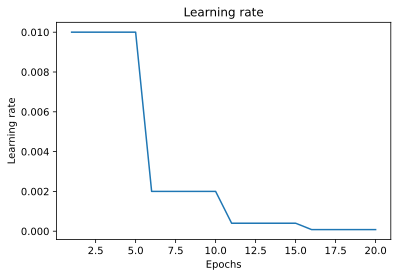

In [ ]:
# visualizando o histŕico da taxa de aprendizagem
plot_learning_rate(history_lr_schedule)

#### **5.6. LambdaCallback**

Outro retorno de chamada útil é `LambdaCallback`. É semelhante a `Callback` e nos permite construir retornos de chamada personalizados dinamicamente.

`LambdaCallback` é construído com as seguintes funções anônimas que serão chamadas no momento apropriado.

- **`on_epoch_begin`**: chamado no início de cada época;
- **`on_epoch_end`**: chamado no final de cada época;
- **`on_batch_begin`**: chamado no início de cada lote;
- **`on_batch_end`**: chamado no final de cada lote;
- **`on_train_begin`**: chamado no início do treinamento do modelo;
- **`on_train_end`**: chamado no final do treinamento do modelo;

 - **`on_epoch_begin`** e **`on_epoch_end`** espera dois argumentos posicionais: `epoch` e `logs`;
 - **`on_batch_begin`** e **`on_batch_end`** espera dois argumentos posicionais: `batch` e `logs` e,
 - **`on_train_begin`** e **`on_train_end`** espera um argumento posicional: `logs`.

Primeiro, vamos importá-lo e criar 3 diferentes `LambdaCallback`.

In [ ]:
# importando a função
from tensorflow.keras.callbacks import LambdaCallback

In [ ]:
# instanciando 3 tipos de "LambdaCallback"
epoch_callback = LambdaCallback(
    on_epoch_begin=lambda epoch, logs: print('Starting epoch {}!'.
                                             format(epoch + 1))
)

batch_loss_callback = LambdaCallback(
    on_batck_end=lambda batch, logs: print('\nAfter batch {}, the loss is {:7.2f}.'.
                                           format(batch, logs['loss']))
)

train_finish_callback = LambdaCallback(
    on_train_end=lambda logs: print('Training finished!')
)

In [ ]:
# criando um modelo
model = create_model()

In [ ]:
# treinando o modelo
history_lambda_callback = model.fit(
    X_train,
    y_test,
    epochs=50,              # mude a época para 2 para fins de demonstração
    validation_split=0.20,  
    batch_size=64,          # mudar para 2000 para fins de demonstração
    verbose=False,
    callbacks=[epoch_callback, 
               batch_loss_callback, 
               train_finish_callback]
)

Starting epoch 1!
Starting epoch 2!
Starting epoch 3!
Starting epoch 4!
Starting epoch 5!
Starting epoch 6!
Starting epoch 7!
Starting epoch 8!
Starting epoch 9!
Starting epoch 10!
Starting epoch 11!
Starting epoch 12!
Starting epoch 13!
Starting epoch 14!
Starting epoch 15!
Starting epoch 16!
Starting epoch 17!
Starting epoch 18!
Starting epoch 19!
Starting epoch 20!
Starting epoch 21!
Starting epoch 22!
Starting epoch 23!
Starting epoch 24!
Starting epoch 25!
Starting epoch 26!
Starting epoch 27!
Starting epoch 28!
Starting epoch 29!
Starting epoch 30!
Starting epoch 31!
Starting epoch 32!
Starting epoch 33!
Starting epoch 34!
Starting epoch 35!
Starting epoch 36!
Starting epoch 37!
Starting epoch 38!
Starting epoch 39!
Starting epoch 40!
Starting epoch 41!
Starting epoch 42!
Starting epoch 43!
Starting epoch 44!
Starting epoch 45!
Starting epoch 46!
Starting epoch 47!
Starting epoch 48!
Starting epoch 49!
Starting epoch 50!
Training finished!


### **6. Outras funções de retorno de chamada**

Junto com as funções acima, existem outros retornos de chamada que você pode encontrar ou usar em seu projeto de Aprendizado Profundo:

- **`Callback`**: esta é a classe base usada para construir um retorno de chamada personalizado. É semelhante, `LambdaCallback` mas muito poderoso;
- **`TensorBoard`**: um retorno de chamada grava um _log_ para `TensorBoard`, que é a excelente ferramenta de visualização do **TensorFlow** e, 
- **`RemoteMonitor`**: um retorno de chamada usado para transmitir eventos para um servidor.

**Chegamos ao fim!**

- Este é tutorial, parte dele foi extraído do `medium` do artigo - [A practical introduction to Keras Callbacks](https://medium.com/@bindiatwork/a-practical-introduction-to-keras-callbacks-in-tensorflow-2-705d0c584966)
